# Hierarchical Model for Abalone Length

Abalone were collected from various sites on the coast of California north of San Francisco. 

Here I'm going to develop a model to predict abalone lengths based on sites and harvest method - diving or rock-picking. 

I'm interested in how abalone lengths vary between sites and harvesting methods. 

This should be a hierarchical model as the abalone at the different sites are from the same population and should exhibit similar effects based on harvesting method. 

The hierarchical model will be beneficial since some of the sites are missing a harvesting method. 

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import sampyl as smp
from sampyl import np
from sampyl.samplers import NUTS
import pandas as pd

Load our data here. This is just data collected in 2017.

In [17]:
pd.options.display.max_rows=500

In [18]:
data = pd.read_csv('Clean2017length.csv')
data

,data year,full lengths,group_id,site_code,Full_ID,Mode
0,2017,181,1.0,5,2017_06_24_005_30_01_01,R
1,2017,182,1.0,5,2017_06_24_005_30_01_01,R
2,2017,183,1.0,5,2017_06_24_005_30_01_01,R
3,2017,191,1.0,5,2017_06_24_005_30_01_01,R
4,2017,191,1.0,5,2017_06_24_005_30_01_01,R
...,...,...,...,...,...,...
6941,2017,201,12.0,72,2017_06_26_072_16_01_12,R
6942,2017,210,12.0,72,2017_06_26_072_16_01_12,R
6943,2017,212,13.0,72,2017_06_26_072_16_01_13,D
6944,2017,229,13.0,72,2017_06_26_072_16_01_13,D


Important columns here are: 

* **full lengths:** length of abalone
* **mode:** Harvesting method, R: rock-picking, D: diving
* **site_code:** codes for 15 different sites

First some data preprocessing to get it into the correct format for our model.

In [19]:
# Convert sites from codes into sequential integers starting at 0
unique_sites = data['site_code'].unique()
site_map = dict(zip(unique_sites, np.arange(len(unique_sites))))
data = data.assign(site=data['site_code'].map(site_map))

# Convert modes into integers as well
# Filter out 'R/D' modes, bad data collection
data = data[(data['Mode'] != 'R/D')]
mode_map = {'R':0, 'D':1}
data = data.assign(mode=data['Mode'].map(mode_map))

## A Hierarchical Linear Model

Here we'll define our model. We want to make a linear model for each site in the data where we predict the abalone length given the mode of catching and the site.

$$ y_s = \alpha_s + \beta_s * x_s + \epsilon $$

where $y_s$ is the predicted abalone length, $x$ denotes the mode of harvesting, $\alpha_s$ and $\beta_s$ are coefficients for each site $s$, and $\epsilon$ is the model error. We'll use this prediction for our likelihood with data $D_s$, using a normal distribution with mean $y_s$ and variance $ \epsilon^2$ :

$$  \prod_s P(D_s \mid \alpha_s, \beta_s, \epsilon) = \prod_s \mathcal{N}\left(D_s \mid y_s, \epsilon^2\right) $$

The abalone come from the same population just in different locations. We can take these similarities between sites into account by creating a hierarchical model where the coefficients are drawn from a higher-level distribution common to all sites.

$$
\begin{align} 
\alpha_s & \sim \mathcal{N}\left(\mu_{\alpha}, \sigma_{\alpha}^2\right) \\
\beta_s & \sim \mathcal{N}\left(\mu_{\beta}, \sigma_{\beta}^2\right) \\
\end{align}
$$

In [20]:
sites = data['site'].values
modes = data['mode'].values
lengths = data['full lengths'].values

# Now define the model (log-probability proportional to the posterior)
def logp(μ_α, μ_β, σ_α, σ_β, site_α, site_β, ϵ):
    
    model = smp.Model()
    
    # Population priors - normals for population means and half-Cauchy for population stds
    model.add(smp.normal(μ_α, sig=500),
              smp.normal(μ_β, sig=500),
              smp.half_cauchy(σ_α, beta=5),
              smp.half_cauchy(σ_β, beta=0.5))
    
    # Priors for site coefficients, sampled from population distributions
    model.add(smp.normal(site_α, mu=μ_α, sig=σ_α),
              smp.normal(site_β, mu=μ_β, sig=σ_β))
    
    # Prior for likelihood uncertainty
    model.add(smp.half_normal(ϵ))
    
    # Our estimate for abalone length, α + βx
    length_est = site_α[sites] + site_β[sites]*modes
    
    # Add the log-likelihood
    model.add(smp.normal(lengths, mu=length_est, sig=ϵ))

    return model()

In [21]:
start = {
    'μ_α': 201.0, 
    'μ_β': 5.0, 
    'σ_α': 1.0, 
    'σ_β': 1.0,
    'site_α': np.ones(len(site_map))*201,
    'site_β': np.zeros(len(site_map)),
    'ϵ': 1.0
}

# Using NUTS is slower per sample, but more likely to give good samples (and converge)
sampler = NUTS.NUTS(logp, start)
chain = sampler(1100, burn=100, thin=2)

/home/thom/venv38/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/thom/venv38/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Progress: [##############################] 1100 of 1100 samples


There are some checks for convergence you can do, but they aren't implemented yet. Instead, we can visually inspect the chain. In general, the samples should be stable, the first half should vary around the same point as the second half.

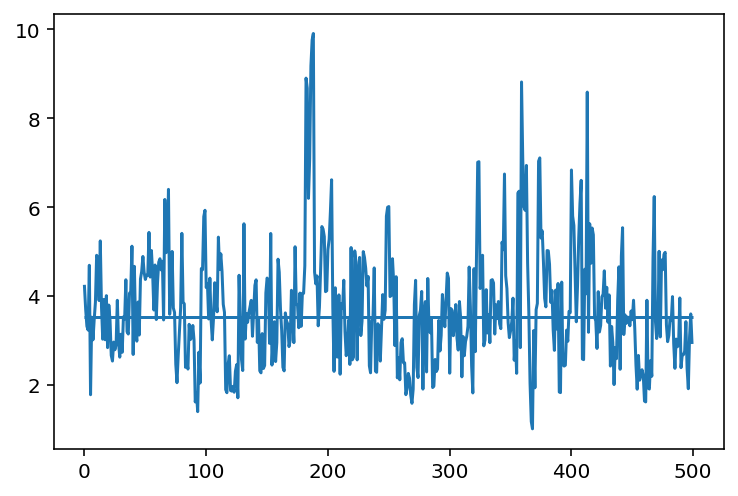

In [28]:
plt.plot(chain.σ_β)
plt.hlines(np.median(chain.σ_β),0,500)

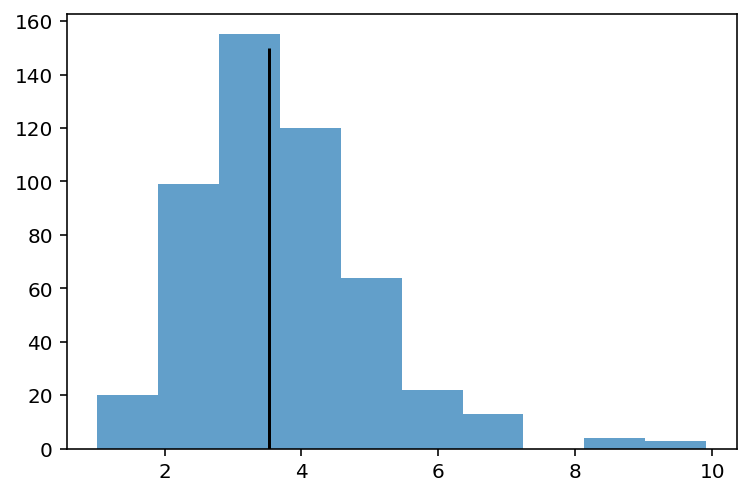

In [33]:
plt.hist(chain.σ_β,alpha=0.7)
plt.vlines(np.median(chain.σ_β),0,150,'k')

With the posterior distribution, we can look at many different results. Here I'll make a function that plots the means and 95% credible regions (range that contains central 95% of the probability) for the coefficients $\alpha_s$ and $\beta_s$.

In [34]:
def coeff_plot(coeff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,5))
    CRs = np.percentile(coeff, [2.5, 97.5], axis=0)
    means = coeff.mean(axis=0)
    ax.errorbar(means, np.arange(len(means)), xerr=np.abs(means - CRs), fmt='o')
    
    ax.set_yticks(np.arange(len(site_map)))
    ax.set_yticklabels(site_map.keys())
    ax.set_ylabel('Site')
    
    ax.grid(True, axis='x', color="#CCCCCC")
    ax.tick_params(axis='both', length=0)
    for each in ['top', 'right', 'left', 'bottom']:
        ax.spines[each].set_visible(False)
    
    return ax

Now we can look at how abalone lengths vary between sites for the rock-picking method ($\alpha_s$).

Text(0.5, 0, 'Abalone Length (mm)')

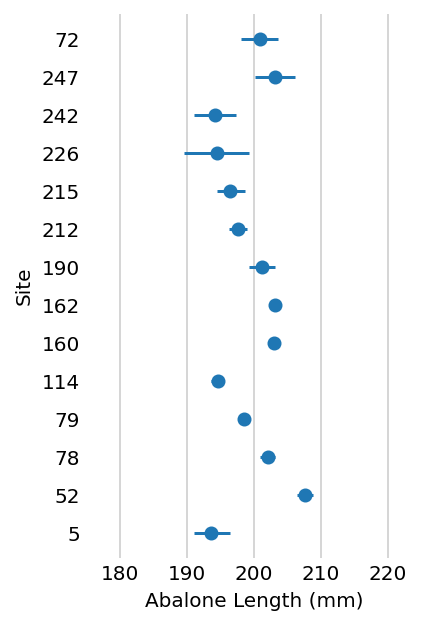

In [35]:
ax = coeff_plot(chain.site_α)
ax.set_xlim(175, 225)
ax.set_xlabel('Abalone Length (mm)')

Here I'm plotting the mean and 95% credible regions (CR) of $\alpha$ for each site. This coefficient measures the average length of rock-picked abalones. We can see that the average abalone length varies quite a bit between sites. The CRs give a measure of the uncertainty in $\alpha$, wider CRs tend to result from less data at those sites. 

Now, let's see how the abalone lengths vary between harvesting methods (the difference for diving is given by $\beta_s$).

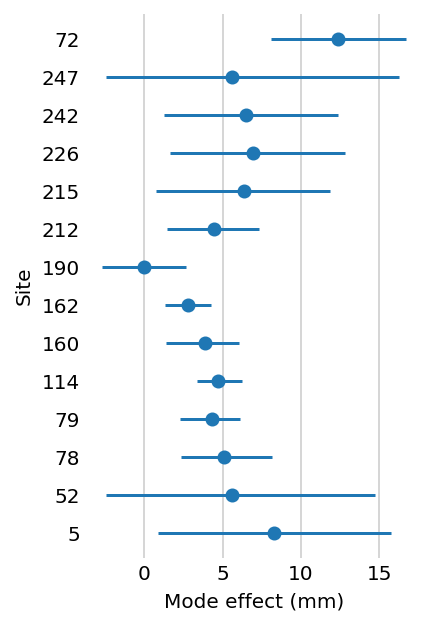

In [36]:
ax = coeff_plot(chain.site_β)
#ax.set_xticks([-5, 0, 5, 10, 15])
ax.set_xlabel('Mode effect (mm)');

Here I'm plotting the mean and 95% credible regions (CR) of $\beta$ for each site. This coefficient measures the difference in length of dive picked abalones compared to rock picked abalones. Most of the $\beta$ coefficients are above zero which indicates that abalones harvested via diving are larger than ones picked from the shore. For most of the sites, diving results in 5 mm longer abalone, while at site 72, the difference is around 12 mm. Again, wider CRs mean there is less data leading to greater uncertainty.

Next, I'll overlay the model on top of the data and make sure it looks right. We'll also see that some sites don't have data for both harvesting modes but our model still works because it's hierarchical. That is, we can get a posterior distribution for the coefficient from the population distribution even though the actual data is missing.

In [37]:
def model_plot(data, chain, site, ax=None, n_samples=20):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,6))
    
    site = site_map[site]
    xs = np.linspace(-1, 3)

    for ii, (mode, m_data) in enumerate(data[data['site'] == site].groupby('mode')):
        
        a = chain.site_α[:, site]
        b = chain.site_β[:, site]
        
        # now sample from the posterior...
        idxs = np.random.choice(np.arange(len(a)), size=n_samples, replace=False)
        
        # Draw light lines sampled from the posterior
        for idx in idxs:
            ax.plot(xs, a[idx] + b[idx]*xs, color='#E74C3C', alpha=0.05)
        
        # Draw the line from the posterior means
        ax.plot(xs, a.mean() + b.mean()*xs, color='#E74C3C')
        
        # Plot actual data points with a bit of noise for visibility
        mode_label = {0: 'Rock-picking', 1: 'Diving'}
        ax.scatter(ii + np.random.randn(len(m_data))*0.04,
               m_data['full lengths'], edgecolors='none',
               alpha=0.8, marker='.', label=mode_label[mode])

    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels('')
    ax.set_ylim(150, 250)
    
    ax.grid(True, axis='y', color="#CCCCCC")
    ax.tick_params(axis='both', length=0)
    
    for each in ['top', 'right', 'left', 'bottom']:
        ax.spines[each].set_visible(False)
    
    return ax

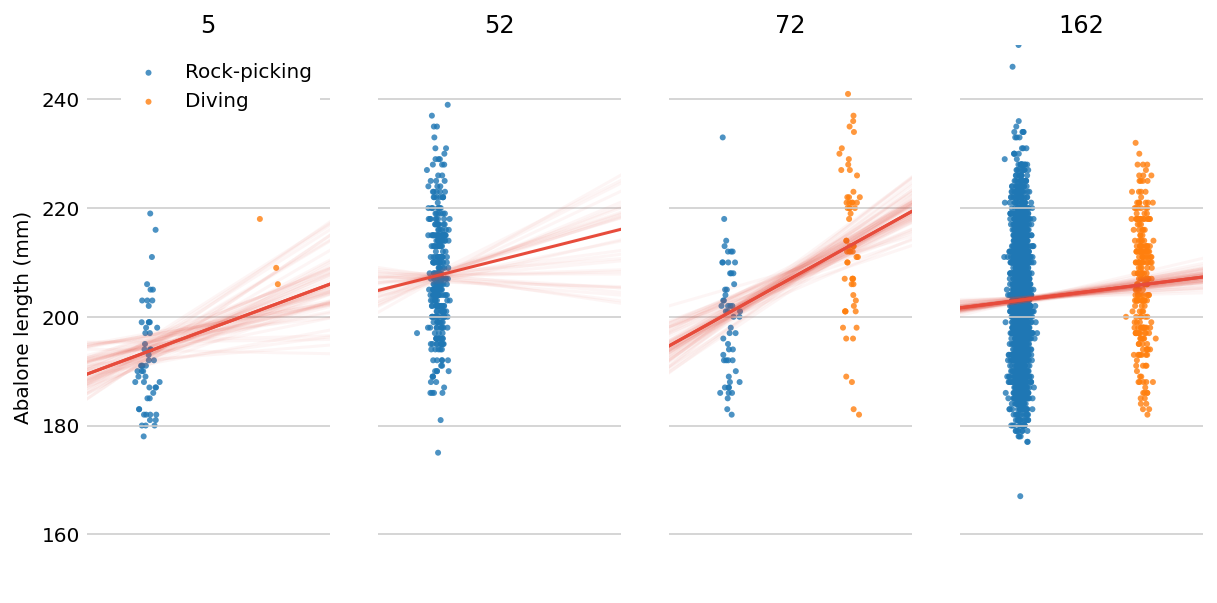

In [38]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=4, sharey=True)

for ax, site in zip(axes, [5, 52, 72, 162]):
    ax = model_plot(data, chain, site, ax=ax, n_samples=30)
    ax.set_title(site)

first_ax = axes[0]
first_ax.legend(framealpha=1, edgecolor='none')
first_ax.set_ylabel('Abalone length (mm)');

For site 5, there are few data points for the diving method so there is a lot of uncertainty in the prediction. The prediction is also pulled lower than the data by the population distribution. Similarly, for site 52 there is no diving data, but we still get a (very uncertain) prediction because it's using the population information.

Finally, we can look at the harvesting mode effect for the population. Here I'm going to print out a few statistics for $\mu_{\beta}$. 

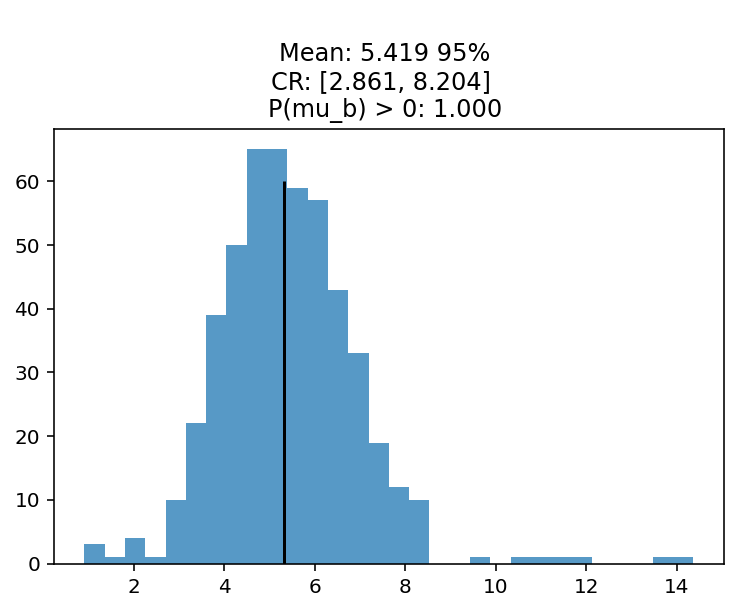

In [49]:
fig, ax = plt.subplots()
ax.hist(chain.μ_β, bins=30,alpha=0.75)
ax.set_title("""
Mean: {:.3f} 95% 
CR: [{:.3f}, {:.3f}]  
P(mu_b) > 0: {:.3f} """.format(b_mean, b_CRs[0], b_CRs[1], p_gt_0))
b_mean = chain.μ_β.mean()
b_CRs = np.percentile(chain.μ_β, [2.5, 97.5])
p_gt_0 = (chain.μ_β > 0).mean()
ax.vlines(np.median(chain.μ_β),0,60,'k')

We can also look at the population distribution for $\beta_s$ by sampling from a normal distribution with mean and variance sampled from $\mu_\beta$ and $\sigma_\beta$.

$$
\beta_s \sim \mathcal{N}\left(\mu_{\beta}, \sigma_{\beta}^2\right)
$$

In [14]:
import scipy.stats as stats

Text(0.5, 0, 'Dive harvesting effect (mm)')

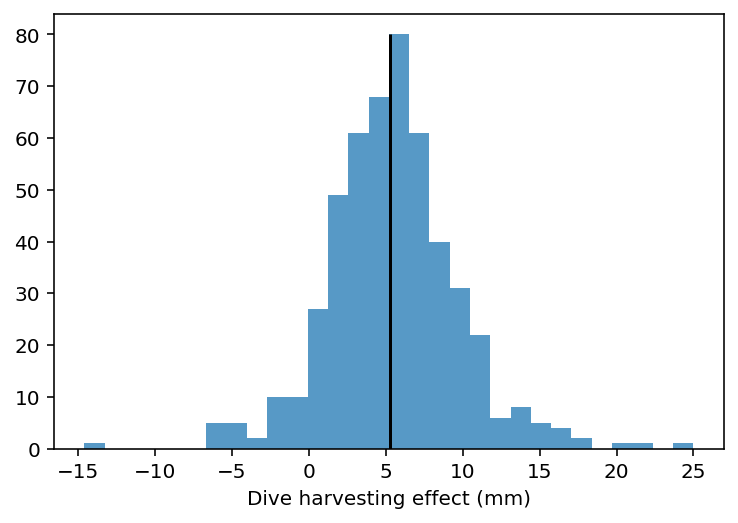

In [55]:
samples = stats.norm.rvs(loc=chain.μ_β, scale=chain.σ_β)
plt.hist(samples, bins=30,alpha=0.75);
plt.vlines(np.median(samples),0,80,'k')
plt.xlabel('Dive harvesting effect (mm)')

It's apparent that dive harvested abalone are roughly 5 mm longer than rock-picked abalone. Maybe this is a bias of the divers to pick larger abalone. Or, it's possible that abalone that stay in the water grow larger.